# Installing Net2Brain

<img src="workshops/data/Net2Brain_Logo.png" width="25%" />

In [ ]:
#!pip install -U git+https://github.com/cvai-roig-lab/Net2Brain

# Step 2: Creating Representational Dissimilarity Matrices (RDMs) using `RDM Creator`

After completing Step 1, where the Feature Extractor extracts features from the specified layers, we can now proceed to Step 2, which involves calculating Representational Dissimilarity Matrices (RDMs) using the RDM Creator's built-in functionality.

We first initialize the RDM Creator class, which contains the function to generate RDMs. The RDM Creator class requires the following parameters:
- **device**: The device on which the RDMs will be generated. This can be 'cpu' or 'cuda'.
- **verbose**: Whether to print the progress of the RDM generation process.

To generate RDMs, the RDM Creator function requires:

- **feature_path**: The path to the .npz files containing the layer features for each image. These files should have a [Batch x Channel x Height x Width] format.
- **save_path** (optional): The location where the generated RDMs will be saved.
- **save_format** (optional): The format in which the RDMs will be saved. This can be 'npz' or 'pt'.
- **distance** (optional): The distance function to generate the RDMs. Default is the correlation distance.
- **standardize_on_dim** (optional): The dimension along which to standardize the features. Default is None.
- **chunk_size** (optional): The number of images to be processed at a time. This is useful when the number of images is too large to fit in memory. Default is all images.
- **multi_timepoint_rdms** (optional): Whether to create separate RDM per timepoint (for video 
models) and at which level. Defaults to None (single RDM from flattened features). If 'clip', 
this creates one RDM per video subclip and flattens the rest of the dimensions, while if 
'all_timepoints' it creates one RDM per video subclip and per timepoint.
- **dim_reduction** (optional): Same as in feature extraction. This provides a second point in the pipeline to apply dimensionality reduction (at the feature loading) and it is only possible when features are saved in separate and not consolidated format. Defaults to None.
- **n_samples_estim**: Same as in feature extraction.
- **n_components** (optional): Same as in feature extraction.
- **srp_before_pca** (optional): Same as in feature extraction.
- **max_dim_allowed** (optional): Same as in feature extraction.
- **pooling** (optional): Pooling method for variable-length features. Options: ``'mean'`` (average across sequence), ``'max'`` (maximum values across sequence), ``'first'`` (use first token/position, e.g., [CLS] token), ``'last'`` (use final token/position). Required when processing transformer/LLM features with different sequence lengths. Defaults to ``None`` for fixed-length features.


The function will then:

- **Output**: Create an RDM with the shape (#Images, #Images) for every specified layer.


In this example, we'll be using the AlexNet features generated earlier in the tutorial. The function can be called as follows:

In [ ]:
from net2brain.rdm_creation import RDMCreator

feat_path = "AlexNet_Feat"
save_path = "AlexNet_RDM"


# Call the Class with the path to the features
creator = RDMCreator(verbose=True, device='cpu') 
save_path = creator.create_rdms(feature_path=feat_path, save_path=save_path, save_format='npz') 


feat_path = "ResNet50_Feat"
save_path = "ResNet50_RDM"


# Call the Class with the path to the feautures
creator = RDMCreator(device='cpu', verbose=True)  
creator.create_rdms(feature_path=feat_path, save_path=save_path, save_format='npz')  # This will create and save the RDMs at the specified save path

### Adding dimensionality reduction at the loading stage
If you wish you can also reduce the dimensionality of the loaded feautures using:

- `srp` (Sparse Random Projection)
- `pca` (Principal Component Analysis)

This is only possible when the features are saved in separate format. If you want to save the features in 
consolidated format, and apply dimensionality reduction, it can only be done at the feature extraction stage and not 
at the loading stage.

In [ ]:
save_path = creator.create_rdms(feature_path=feat_path, save_path=save_path, save_format='npz', dim_reduction='srp') 

## Distance functions and normalization

The default distance function is the correlation distance. To use a different distance function, we can specify the distance function in the **distance** parameter. The available distance functions can been seen by calling the **distance_functions** method of the RDMCreator. We created synonyms for the distance functions to make it easier to use them (i.e. l2 == euclidean). The available distance functions are:

In [ ]:
creator.distance_functions()

You can also use custom distance functions by passing a function to the **distance** parameter. The function should take one argument `x` of shape `(N, D)`, which represents the features (dimension `D`) of the `N` stimuli and return a pairwise distance matrix of shape `(N, N)`. For example, we can use the cosine distance function as follows:

In [ ]:
import torch.nn.functional as F

def custom_cosine(x):
    x_norm = F.normalize(x, p=2, dim=1)
    return 1 - (x_norm @ x_norm.T)

creator.create_rdms(feature_path=feat_path, save_path='AlexNet_RDM_custom', save_format='npz', distance=custom_cosine)

## Feature standardization 

The input feature are not standardized by default. To standardize the input features, we can specify the dimension along which to standardize the features using the **standardize_on_dim** parameter. For an input of shape (num_stimuli, num_features) three options are available:
- `standardize_on_dim=None`: No standardization is applied.
- `standardize_on_dim=0`: Standardize along the first dimension (num_stimuli).
- `standardize_on_dim=1`: Standardize along the second dimension (num_features).

## Accessing and Visualizing RDMs

The `LayerRDM` class provides a convenient way to access and visualize the Representational Dissimilarity Matrix (RDM) for a single layer of data. To optimize memory usage, only the upper triangular part of the RDM is stored. The `LayerRDM` class efficiently manages the conversion between this upper triangular format and the full square RDM, and also facilitates visualization.

In [ ]:
from net2brain.rdm_creation import LayerRDM

rdm = LayerRDM.from_file("AlexNet_RDM/RDM_features_0.npz")
print("Class:", rdm)
rdm.plot(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The RDM data can be accessed through the `data` attribute, which returns the full square RDM:

In [ ]:
rdm.data

## RDMs of arbitrary data

The functional API provides a straightforward way to calculate the RDM for any arbitrary data. The `dist` function from ` net2brain.rdm.dist_utils` is designed to handle this process efficiently, supporting both individual feature matrices and batches of feature matrices. Key features of this function include:

   - **Sanity Checks**: Ensures that inputs are valid and correctly formatted.
   - **Data Types and Devices**: Automatically handles appropriate data types and computational devices.
   - **Chunking**: Efficiently processes large datasets by breaking them into smaller chunks.

For users who only need to calculate the distance, the raw function can be accessed directly from `net2brain.rdm.dist`.

In [ ]:
import torch
from net2brain.rdm.dist_utils import dist
from net2brain.rdm.dist import correlation

# Generate random example data
N, D = 10, 100
feature = torch.rand(N, D)

# Calculate RDM
raw_rdm = dist(feature, metric="correlation", chunk_size=None, verbose=True, device='cpu')
# or
raw_rdm = correlation(feature)

print("Shape of RDM (N x N):", raw_rdm.shape)

# Temporally resolved RDM construction for video features

For video models, it is often useful to create temporally resolved RDMs that capture the representational dissimilarities at different time points. The `multi_timepoint_rdms` parameter in the `create_rdms` function allows for this functionality. 

When set to `'clip'`, the function creates one RDM per video subclip, flattening the other 
dimensions. Make sure that your features were extracted with the keyword argument `agg_frames` 
either set to None or 'within_clips' during feature extraction for this to work properly.

When set to `'all_timepoints'`, it creates one RDM per video subclip and per timepoint. Make sure
that your features were extracted with the keyword argument `agg_frames` either set to None or 
'across_clips' during feature extraction for this to work properly.

In [ ]:
from net2brain.rdm_creation import RDMCreator

feat_path = 'VideoModel_TimeResolvedFeat'
save_path = 'VideoModel_TimeResolvedRDM'

creator = RDMCreator(device='cpu', verbose=True)  
creator.create_rdms(feature_path=feat_path, save_path=save_path, save_format='npz', multi_timepoint_rdms='all_timepoints')

## RDMs with Variable-Length Features
When working with features that have variable sequence lengths (such as text or time-series data), pooling is required to create uniform feature representations before calculating RDMs:

/Users/domenicbersch/anaconda3/envs/N2B/lib/python3.10/site-packages/net2brain/rdm/feature_iterator.py:352: UserWarning: FeatureIterator is not optimized for NPZ_SEPARATE format. Consider using NPZ_CONSOLIDATED format instead.
  warnings.warn("FeatureIterator is not optimized for NPZ_SEPARATE format. "


Creating RDMs:   0%|          | 0/2 [00:00<?, ?it/s]

Created and plotted RDM for layer: encoder.layer.1


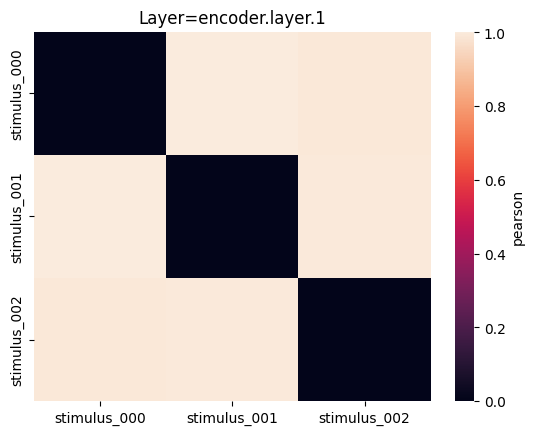

In [3]:
import numpy as np
from pathlib import Path
from net2brain.rdm_creation import RDMCreator
from net2brain.rdm.rdm import LayerRDM
import shutil

# Create temporary dummy data
temp_dir = Path("./temp_features")
temp_dir.mkdir(exist_ok=True)

# Variable-length features (like BERT tokens)
for i, seq_len in enumerate([8, 12, 6]):
    data = {}
    for layer in range(2):
        data[f"encoder.layer.{layer}"] = np.random.randn(seq_len, 768).astype(np.float32)
    np.savez(f"temp_features/stimulus_{i:03d}.npz", **data)

# Create RDMs with pooling
creator = RDMCreator(verbose=True, device='cpu')
save_path = creator.create_rdms(
    feature_path="temp_features", 
    pooling="mean",
    save_format='npz'
)

# Plot the first RDM
rdm_files = list(save_path.glob("*.npz"))
rdm = LayerRDM.from_file(rdm_files[0])
rdm.plot()

# Clean up temporary files
shutil.rmtree("temp_features", ignore_errors=True)
shutil.rmtree(save_path, ignore_errors=True)